This script loads in the synchronised data and sticks it in a collection of pandas dataframes for analysis

2 July 2020


In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import regex as re
import itertools as it
import matplotlib.pyplot as plt
from wavelet_scripts import wt, wcompare
from wavelet_scripts import plot_wavelet_signal, do_stats #,plot_stats


original_data_root = os.path.join('C:\\', 'Users', 'Sabrina', 'Documents', 'master_thesis','#study_27_07_20')
data_dir = os.path.join('.', '2', 'data')

working_dir = os.path.join('.', '2', 'analysis')

# Give each device a simple peron identifier, A or B
device_map = {'A':'eSense_0237', 'B':'eSense_0308'}
experiment_ids = ['005','006','007', '008']
trials = range(3,15) # 01 and 02 are missing from experiment 3 for some reason




def rename_and_apply_func_to_data(src_dir, experiment_number, esense_folder, func='shutil.copy', new_dir='.', test_script = False):
    '''adapted J. Matharu script to rename and move the original data to new director
        + added the func='' to allow definition of a new function other than os.rename 
        but func must take the same parameters as os.rename, i.e. src and dest!
        (set test_script=True to just print the output but not actually do the command)
    '''
    destination_files = []
    
    print( '-----\n Applying ' + func + ' to the following files: \n-----\n' )
    path = os.path.join( src_dir, experiment_number, esense_folder, 'trials' )
    
    # adapt to extract the recording number from the original file name!    
    files = os.listdir(path)
    for file in files:
        if file.endswith(".xlsx"):
            # trick to extract the numeric part of the filename string, i.e. 01, or 02...
            trial = "".join(re.findall('\d+', file))
            src = os.path.join(path, file) 
            dest = os.path.join( new_dir, "experiment_" + experiment_number + "_" + esense_folder + "_" + "trial_" + trial + ".xlsx")
            
            print('{} -> {}'.format(src,dest))
            destination_files.append(dest)
            if not test_script:
                # apply the function
                eval('{}(\'{}\',\'{}\')'.format(func,src,dest) )
    print('---done---')
    
    return destination_files
    
# test the function, e.g. to copy files 
#rename_and_apply_func_to_data(os.path.join(original_data_root), '001', 'eSense_0237', func='shutil.copy', new_dir=data_dir, test_script=True)

In [2]:
if False:
    # copy over the files...
    data_files = {}

    # obtain all the possible permutations of person and experiment and copy the relevant files over
    for person, experiment in it.product(device_map.keys(), experiment_ids):
        print( 'copying {} {}'.format(person,experiment))
        data_files[(person,experiment)] = rename_and_apply_func_to_data(os.path.join(original_data_root), experiment, device_map[person],  func='shutil.copy', new_dir=data_dir )


In [3]:
src_dir = original_data_root

# Load all the synchronised data into a convenient dictionary of dataframes
# (note: this works from the original data.. no need to copy files!)

AllData = {experiment: {} for experiment in experiment_ids}

for person, experiment in it.product(device_map.keys(), experiment_ids):
    path = os.path.join( src_dir, experiment, device_map[person], 'trials' )
    filenames = os.listdir(path)
    
    for file in filenames:
        if file.endswith(".xls"):
            src = os.path.join(path, file)
            # trick to extract the numeric part of the filename string, i.e. 01, or 02...
            trial = "".join(re.findall('\d+', file))
            # load the data
            trial_data = pd.read_excel(src,name=person)
            #trial_data.set_index('time', inplace=True)
            #trial_data.index = pd.TimedeltaIndex(trial_data.index*10e5)
        
            AllData[experiment][int(trial),person] = trial_data
            
            

# so to access, say, experiment 1, trial 19, person, A, we would run this:
df = AllData[experiment_ids[0]][1,'A']
df.head()


,time,acc_X_in_G,acc_Y_in_G,acc_Z_in_G,gyro_X_in_deg_s,gyro_Y_in_deg_s,gyro_Z_in_deg_s,activity_label,activity,on_off_label
0,135720,-0.863403,-0.462646,0.360962,-30.335366,-46.920732,32.317073,7,Experiment,ON
1,135722,-0.821045,-0.398438,0.379028,-34.908537,-44.573171,32.195122,7,Experiment,ON
2,135810,-0.780762,-0.415405,0.373779,-20.731707,-56.676829,34.847561,7,Experiment,ON
3,135812,-0.826904,-0.364868,0.419800,-25.457317,-57.560976,40.975610,7,Experiment,ON
4,135812,-0.800659,-0.368164,0.449951,-20.487805,-36.006098,46.067073,7,Experiment,ON


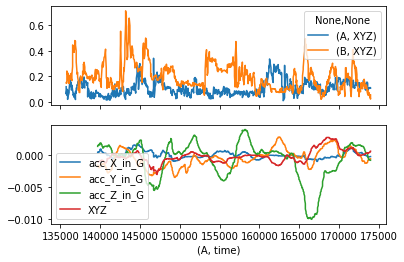

In [4]:
# Now lets clean up the data so we can use it more easily
## df = pd.concat( [AllData['001'][1,'A'], AllData['001'][1,'B'] ], axis=1, keys=['A','B'])

def extract_movement_dyads( data_list, people = ['A','B']): #, timestamps = None ):
    '''extract the useful movement data from pairs or participants
       data list should be a list of dataframes, with each frame representing a person
       (represented by the list of people)
       this function will then zero-mean the accelerometer data and calculate the euclidean
       norm of the x,y, and z directions.
    '''    

    df = pd.concat( data_list, axis=1, keys=people)
    df.dropna(inplace=True)
    df.index = df[(people[0],'time')] #!HACKY!
    
    
    # zero the accelerometer data around its mean
    df = df.loc[:,(people,['acc_X_in_G','acc_Y_in_G','acc_Z_in_G'])]
    df = df-df.apply(np.nanmean)
    # calculate the euclidean norm of the x, y, and z signals for each person
    ### xyz = df.groupby(level=0,axis=1).apply(np.linalg.norm,axis=1)
    for person in people:
        df.loc[:,(person,'XYZ')] = df[person].apply(np.linalg.norm,axis=1)   
    return df


def plot_euclid(df, start, limit): 
    start = df.index[0] + start
    limit = df.index[0] + limit
    if limit > df.index[-1]: 
        limit = df.index[-1]
    ### plot data 
    # accelerometer
    plt.figure(figsize=(15,10))
    plt.plot(df.loc[start:limit, 'acc_X_in_G'], label='X-part._1', color='deepskyblue')
    plt.plot(df.loc[start:limit, 'acc_Y_in_G'], label='Y-part._1', color='steelblue')
    plt.plot(df.loc[start:limit, 'acc_Z_in_G'], label='Z-part._1', color='blue')
    plt.plot(df.loc[start:limit, 'XYZ'], label='euclidean norm', color='yellow')
    
    plt.xlabel('time [ms]')
    plt.ylabel('accelerometer [G]')

    plt.legend(loc='center left', bbox_to_anchor=(1,0.6), title="Legend")

    plt.show

##
# look at a specific trial 
experiment = experiment_ids[0]
trial = 1

df = extract_movement_dyads([AllData[experiment][trial,'A'], AllData[experiment][trial,'B'] ], ['A','B'])

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

df.loc[:,(['A','B'],'XYZ')].plot(ax=ax1)

# calculate the rolling covariance between A and B on XYZ over 100 sample window
corrAB = df['A'].rolling(100,axis=1).cov(df['B'])
corrAB.plot(ax=ax2, label='corr')
plt.legend()

#plot_euclid(df['A'], 0, 10000)

{'005': {3:               A_XYZ     B_XYZ
(A, time)                    
270812     0.095889  0.094696
270813     0.065099  0.079388
270901     0.079120  0.067207
270901     0.095274  0.059924
270992     0.050434  0.119389
...             ...       ...
311402     0.107544  0.363269
311403     0.110992  0.308001
311492     0.089262  0.255259
311493     0.095177  0.229404
311494     0.094084  0.347577

[1015 rows x 2 columns], 4:               A_XYZ     B_XYZ
(A, time)                    
324182     0.101311  0.102815
324183     0.201651  0.077660
324272     0.106854  0.086252
324362     0.168866  0.069432
324364     0.176325  0.079572
...             ...       ...
363242     0.044854  0.443807
363244     0.046321  0.443019
363331     0.061330  0.414635
363332     0.085999  0.428354
363335     0.072567  0.418392

[978 rows x 2 columns], 5:               A_XYZ     B_XYZ
(A, time)                    
374493     0.303097  0.361184
374494     0.289519  0.366928
374495     0.330348  0.362290
3

Text(0.5, 0, 'time')

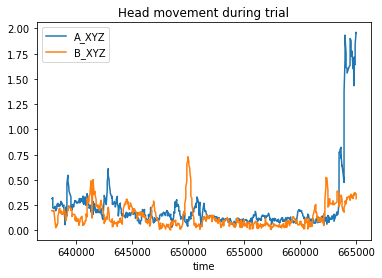

In [5]:
## Let's calculate this across all data
ProcessedData = {experiment: {} for experiment in experiment_ids}
for experiment in experiment_ids:
    for trial in trials:
        df = extract_movement_dyads([AllData[experiment][trial,'A'], AllData[experiment][trial,'B'] ], ['A','B'])
        # flatten the columns to make it easier to work with, and use only the XYZ signals
        df.columns = df.columns.map('_'.join)
        ProcessedData[experiment][trial] = df[['A_XYZ','B_XYZ']]
        
print(ProcessedData)

ProcessedData[experiment][trial].plot()
plt.title('Head movement during trial')
plt.xlabel('time')


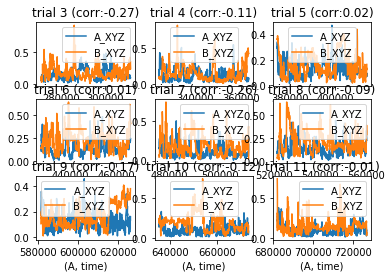

In [6]:
# plot some examples of this
plot_trials = [3,4,5, 6,7,8, 9,10,11]
experiment = experiment_ids[0]

fig = plt.figure()
for i, trial in enumerate(plot_trials):
    ax = fig.add_subplot(3,3,i+1)
    df = ProcessedData[experiment][trial]
    df.plot(ax=ax)
    ax.set_title('trial {} (corr:{})'.format(trial,np.round(df.corr().values[0,1],2)))

# But what are the labels for each of these? 

Now we are just about ready to analyse the data statistically across trials!

In [7]:
#d = ProcessedData[experiment][3].fillna(0)
#d.index = pd.TimedeltaIndex(d.index*10e6)
#d.index[3]-d.index[2]

In [8]:

## Plot and stats scripts:


def plot_stats( freq_analysis_face, freq_analysis_back, ttl_ff='p', ttl_bb='n', ttl = 'p-n' ):
    
    from scipy.stats import ttest_1samp, ttest_rel
    from scipy.signal import butter, lfilter
    from statsmodels.stats.multitest import fdrcorrection
    
    sig_level = 0.05
    fdr_level = 0.05
    
    
    # average coherence levels
    u_face = freq_analysis_face.mean(axis=1)
    u_back = freq_analysis_back.mean(axis=1)
    
    # Do some significance statistics on the results
    diff_face_back = freq_analysis_face - freq_analysis_back
    
    # calculate the stats -- using ttest_rel if the same particpants are being compared
    #stat, pval = ttest_rel( freq_analysis_face, freq_analysis_back, axis=1, na
    t_stat, pval = ttest_1samp( diff_face_back, 0, axis=1, nan_policy='propagate' )
    pval[np.isnan(pval)]=1 
    # calculate cohen's d (https://www.socscistatistics.com/effectsize/default3.aspx)
    u_cohen_d = (freq_analysis_face.mean(1)-freq_analysis_back.mean(1)) / ((freq_analysis_face.std(1)**2 + freq_analysis_back.std(1)**2)/2).apply(np.sqrt)
    u_diff_sig = u_cohen_d[pval<sig_level]

    # FDR correction
    reject_fdr, pval_fdr = fdrcorrection(pval, alpha=0.05, method='indep')
    u_diff_fdr = u_cohen_d[pval_fdr<fdr_level]
    
#    t_stat, pval, pval_fdr, u_cohen_d, u_diff_sig, u_diff_fdr = do_stats(freq_analysis_face,freq_analysis_back,0.05,0.05)

    face_std_err2 = freq_analysis_face.std(1).div(np.sqrt(freq_analysis_face.shape[1])).fillna('pad')
    back_std_err2 = freq_analysis_back.std(1).div(np.sqrt(freq_analysis_back.shape[1])).fillna('pad')
    
    # prepare the 1st subplot showing coherence results
    fig,axes = plt.subplots(2,1,sharex=True,sharey=False)
    #diff_face_back.plot( ax=axes[0] )
    u_face.plot(ax=axes[0], label=ttl_ff, color = '#0000FF') # blue
    axes[0].fill_between( x=np.double(u_face.index), y1=(u_face-face_std_err2).values, y2=(u_face+face_std_err2).values, alpha=0.2, edgecolor='#0000FF', facecolor='#0000FF')

    u_back.plot(ax=axes[0], label=ttl_bb, color = '#FF0000', linestyle=':') # red
    axes[0].fill_between( x=np.double(u_back.index), y1=(u_back-back_std_err2).values, y2=(u_back+back_std_err2).values, alpha=0.2, edgecolor='#FF0000', facecolor='#FF0000')

    
    axes[0].invert_xaxis()
    axes[0].set_xscale('log')
#    axes[0].set_xlabel('log period (s)')

    if max([u_face.max(0), u_back.max(0)]) > 0.5:
        axes[0].set_ylim([0.1,1]) 
        print('max axes')
    elif max([u_face.max(0), u_back.max(0)])>0.25:
        axes[0].set_ylim([0.1,0.5])
    else:
        axes[0].set_ylim([0.1,0.3])
    axes[0].legend()
    axes[0].set_ylabel('avg. coherence')
    
    # 2nd subplot -- showing difference 
    u_cohen_d.plot( ax=axes[1], label='d')
    # overlay significance values on cohen's d difference measure
    try:
        u_diff_sig.plot( ax=axes[1], label='p<0.05', color='b', marker='.', linestyle='')
    except:
        pass
   
    try:
        u_diff_fdr.plot( ax=axes[1], label='p(FDR)<0.05', color='r', marker='*', linestyle='')
    except:
        pass

    axes[1].legend()
    axes[1].invert_xaxis()
    axes[1].set_xscale('log')
    axes[1].set_xlabel('log period (s)')
    #axes[1].set_xlim([100,0.1])
    if u_cohen_d.apply(np.abs).max() < 1:
        axes[1].set_ylim([-1,1])
    axes[1].set_ylabel('effect size (d)')
    axes[1].set_xlim([0.5,12])
    fig.suptitle(ttl)


In [9]:

# Wavelet parameters
dj=1/6 
s0=0.5 
J=32


def make_cross_wavelet_coherence(d1,d2,s0,J,dj ):
    # d1, d2 -- data signals vectors
    # s0 -- wavelet lowest scale 
    # J -- number of scales
    # dj -- scales per octave 
    
    w1,coi = wt(d1,dj=dj,s0=s0,J=J)
    w2,coi = wt(d2,dj=dj,s0=s0,J=J)

    # cross wavelet and coherence
    wct, w12 = wcompare( w1, w2, dj)

    return wct, w12, coi, w1, w2


CrossWavelets = {experiment:{} for experiment in experiment_ids}


for experiment in experiment_ids:
    # Obtain cross wavelet transforms for all trials
    WCT_all = {}
    XWT_all = {}
    for trial in trials:
        print('Generating wavelet for %s' %trial)

        d = ProcessedData[experiment][trial].fillna(0)
        d.index = pd.TimedeltaIndex(d.index*10e6)    #!!! CHECK THIS!!!
        d = d.resample('10L').median().fillna(0)

        WCT_all[trial], XWT_all[trial], coi, w1, w2 = make_cross_wavelet_coherence(d['A_XYZ'],d['B_XYZ'], s0=0.5, J=36, dj=1/6)

    CrossWavelets[experiment] = {'c': WCT_all, 'x': XWT_all}
    

Generating wavelet for 3
Generating wavelet for 4
Generating wavelet for 5
Generating wavelet for 6
Generating wavelet for 7
Generating wavelet for 8
Generating wavelet for 9
Generating wavelet for 10
Generating wavelet for 11
Generating wavelet for 12
Generating wavelet for 13
Generating wavelet for 14
Generating wavelet for 3
Generating wavelet for 4
Generating wavelet for 5
Generating wavelet for 6
Generating wavelet for 7
Generating wavelet for 8
Generating wavelet for 9
Generating wavelet for 10
Generating wavelet for 11
Generating wavelet for 12
Generating wavelet for 13
Generating wavelet for 14
Generating wavelet for 3
Generating wavelet for 4
Generating wavelet for 5
Generating wavelet for 6
Generating wavelet for 7
Generating wavelet for 8
Generating wavelet for 9
Generating wavelet for 10
Generating wavelet for 11
Generating wavelet for 12
Generating wavelet for 13
Generating wavelet for 14
Generating wavelet for 3
Generating wavelet for 4
Generating wavelet for 5
Generating

In [10]:
# before calculating the average cross wavelet, cut out about 5s of data from the start and end

cut = 100 * 5 #cut samples (100Hz)  

avg_xwt = {ex: pd.DataFrame({trial: CrossWavelets[ex]['x'][trial].iloc[cut:-cut,:].abs().mean(axis=0) for trial in trials}) for ex in experiment_ids}
avg_coh = {ex: pd.DataFrame({trial: CrossWavelets[ex]['c'][trial].iloc[cut:-cut,:].abs().mean(axis=0) for trial in trials}) for ex in experiment_ids}


In [11]:
# load labelling from the excel file
Labels = {experiment: {} for experiment in experiment_ids}

for experiment in experiment_ids:
    fn = os.path.join(original_data_root,experiment,'experiment_'+experiment+'_verbs.xlsm')
    df = pd.read_excel(fn, sheet_name='recording data')
    df = df.rename(columns={'Trial Number':'trial','verb':'A_verb','pos_neg':'A_pn','verb.1':'B_verb','pos_neg.1':'B_pn'})
    # only consider actual trials, and ensure that they are numeric
    df = df[ df['trial'].str.contains('Trial') ]
    df['trial'] = df['trial'].str.replace('([a-zA-z]+)','').apply(pd.to_numeric)
    # Add 2 to the trial numbers so that they match the data files #!! HACK !!
    df['trial'] = df['trial'] + 2
    df.set_index('trial', inplace=True)
    # single column label of emotional valence (both pos, both neg, mixed)
    df['valence'] = 'm'
    df.loc[(df[['A_pn','B_pn']]=='p').all(axis=1),'valence'] = '+'
    df.loc[(df[['A_pn','B_pn']]=='n').all(axis=1),'valence'] = '-'
    
    df.loc[(df['A_pn']=='p')&(df['B_pn']=='n'),'valence'] = '>'
    df.loc[(df['A_pn']=='n')&(df['B_pn']=='p'),'valence'] = '<'
    
    Labels[experiment] = df[['A_verb','A_pn','B_verb','B_pn','valence']]


Labels[experiment_ids[0] ]

,A_verb,A_pn,B_verb,B_pn,valence
trial,,,,,
3,motivate,p,displease,n,>
4,comfort,p,displease,n,>
5,displease,n,attack,n,-
6,motivate,p,attack,n,>
7,motivate,p,comfort,p,+
8,comfort,p,attack,n,>
9,displease,n,motivate,p,<
10,displease,n,comfort,p,<
11,attack,n,displease,n,-


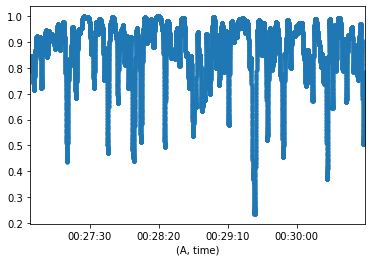

In [12]:
CrossWavelets[experiment]['c'][3][0.5].plot(linestyle='', marker='.')

max axes


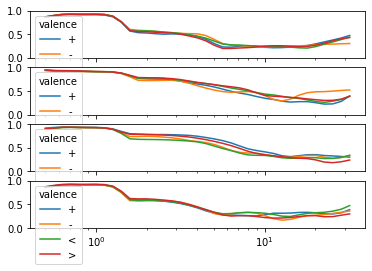

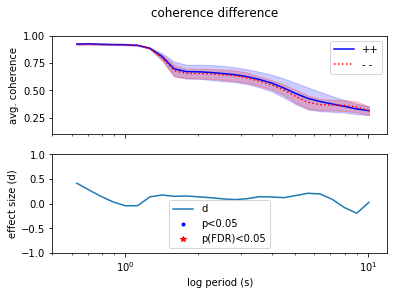

In [13]:
# coherence difference between pairs of participants (i.e. N=3)
fig=plt.figure()
pos = pd.DataFrame()
neg = pd.DataFrame()



for i,ex in enumerate(experiment_ids):
    
    ax = fig.add_subplot(len(experiment_ids),1,i+1)
    # average over all trials in relevant group
    avg_coh[ex].groupby(by=Labels[ex].valence, axis=1).mean().plot(ylim=[0,1], ax=ax )
    ax.set_xscale('log')
    pos[i]= avg_coh[ex].loc[:,Labels[ex].valence=='+'].mean(axis=1)[.6:11]
    neg[i]= avg_coh[ex].loc[:,Labels[ex].valence=='-'].mean(axis=1)[.6:11]

plot_stats( pos, neg, ttl_ff='++', ttl_bb='- -', ttl='coherence difference')


max axes
max axes


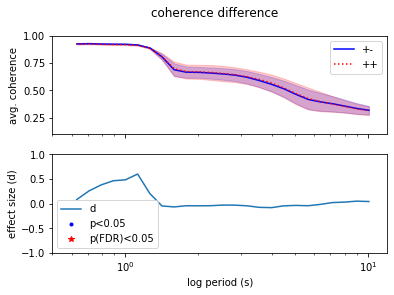

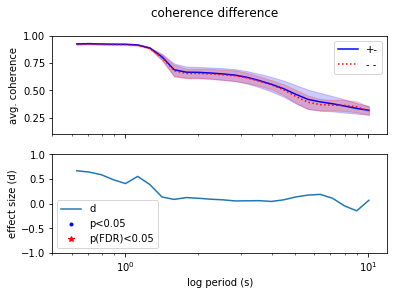

In [14]:

posneg = pd.DataFrame()

for i,ex in enumerate(experiment_ids):
    posneg[i]= avg_coh[ex].loc[:,(Labels[ex].valence=='>') | (Labels[ex].valence=='<')].mean(axis=1)[.6:11]
    
plot_stats( posneg, pos, ttl_ff='+-', ttl_bb='++', ttl='coherence difference')

plot_stats( posneg, neg, ttl_ff='+-', ttl_bb='- -', ttl='coherence difference')


In [15]:
(Labels[ex].valence=='>')|(Labels[ex].valence=='<')

trial
3      True
4     False
5     False
6      True
7      True
8      True
9      True
10    False
11    False
12     True
13     True
14     True
Name: valence, dtype: bool

C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <

max axes
max axes


C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Sabrina\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <

max axes
max axes


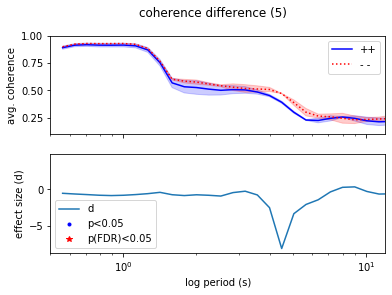

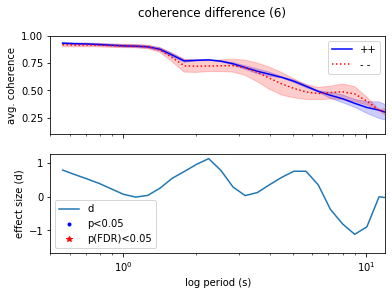

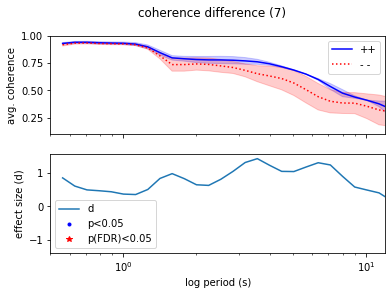

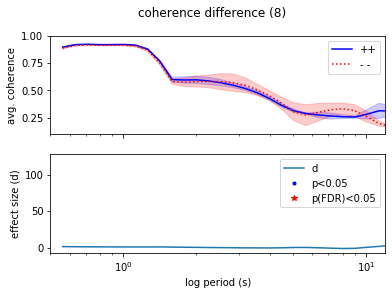

In [16]:

# lets do it for intra-pair (stats over trials, N = 18)
for ex in experiment_ids:
    pos= avg_coh[ex].loc[:,Labels[ex].valence=='+']
    neg= avg_coh[ex].loc[:,Labels[ex].valence=='-']
    plot_stats( pos[0.51:], neg[0.51:], ttl_ff='++', ttl_bb='- -', ttl='coherence difference (%s)' % ex.strip('00'))

In [17]:
#ex='002'
#verbs = pd.DataFrame()
#for ex in experiment_ids:
#    verbs =+ avg_coh[ex].groupby(by=Labels[ex].A_verb, axis=1).mean()
#verbs=verbs/3


In [18]:
ProcessedData[ex][trial].sum().sum()

260.8099378014505

 lets look at the original data and the energy in the signals..

In [19]:

energy = pd.concat({ex:pd.concat({trial:ProcessedData[ex][trial].sum() for trial in trials}).unstack() for ex in experiment_ids})
for ex in experiment_ids:
    for trial in trials:
        energy.loc[(ex,trial),'valence'] = Labels[ex].loc[trial,'valence'] 
        
#energy = energy.reset_index().rename(columns={'level_0':'experiment','level_1':'trial'})
energy = energy.reset_index(level=0).rename(columns={'level_0':'experiment'})
energy.index.name='trial'

In [38]:
from scipy.stats import sem

# calculate the overall energy for each trial and then groupby condition
#energy.groupby(['valence','experiment']).mean()
energy['sum'] = energy[['A_XYZ','B_XYZ']].sum(axis=1)

condition_results = energy.groupby(['valence','experiment']).mean()['sum']
print(condition_results)

# calculate standard error of energy
energy['se'] = sem(energy[['A_XYZ','B_XYZ']], axis=1)
std_err_results = energy.groupby(['valence','experiment']).mean()['se']
print(std_err_results)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
condition_results['+'].plot(marker='+',linestyle='', color='blue', ax=ax, yerr=std_err_results['+'])
condition_results['-'].plot(marker='_',linestyle='', color='red', ax=ax, yerr=std_err_results['-'])

#condition_results['+'].plot(marker='+', linestyle=':', color='blue', ax=ax)
#condition_results['-'].plot(marker='_', linestyle=':', color='red', ax=ax)
#condition_results['<'].plot(marker='<', linestyle=':', color='cyan', ax=ax)
#condition_results['>'].plot(marker='>', linestyle=':', color='cyan', ax=ax)
ax.set_ylabel('Average Movement energy')
ax.legend(['positive', 'negative'])



valence  experiment
+        005           312.046308
         006           292.428835
         007           282.614373
         008           243.844717
-        005           285.164954
         006           231.675155
         007           261.707181
         008           188.168016
<        005           280.571228
         006           249.316608
         007           276.388382
         008           222.491535
>        005           330.037550
         006           249.699981
         007           272.564901
         008           218.229051
Name: sum, dtype: float64
valence  experiment
+        005           41.902220
         006           10.989445
         007           50.258612
         008           32.266731
-        005           17.761468
         006           22.610259
         007           14.342019
         008           26.945938
<        005           28.581330
         006           23.006540
         007           37.982425
         008           16.5

valence  experiment  trial
+        005         7        263.883228
                     13       360.209388
         006         8        268.177787
                     14       316.679883
         007         7        247.461993
                     13       317.766752
         008         4        253.000756
                     10       234.688678
-        005         5        285.291179
                     11       285.038729
         006         7        279.156073
                     13       184.194236
         007         8        233.850623
                     14       289.563738
         008         5        188.922640
                     11       187.413392
<        005         9        330.749323
                     10       270.951393
                     12       230.114403
                     14       290.469793
         006         9        256.180437
                     10       234.774052
                     11       270.459223
                     12       

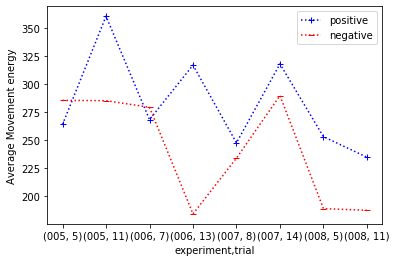

In [21]:
trial_results = energy.groupby(['valence','experiment','trial']).mean()['sum']
print(trial_results)

# the following trials are not strictly comparable!
fig=plt.figure()
ax = fig.add_subplot(1,1,1)
trial_results['+'].plot(marker='+', linestyle=':', color='blue', ax=ax)
trial_results['-'].plot(marker='_', linestyle=':', color='red', ax=ax)
#trial_results['<'].plot(marker='<', linestyle=':', color='cyan', ax=ax)
#trial_results['>'].plot(marker='>', linestyle=':', color='cyan', ax=ax)
ax.set_ylabel('Average Movement energy')
ax.legend(['positive', 'negative'])

In [22]:
#sample estimate of the population standard deviation (sample standard deviation) divided by the square root of the sample size 

SE_plus = trial_results['+'].groupby('experiment').std().div( trial_results['+'].groupby('experiment').count() )
SE_neg = trial_results['-'].groupby('experiment').std().div( trial_results['+'].groupby('experiment').count() )


In [23]:
%matplotlib
x= pd.to_numeric(condition_results['+'].index)
y= condition_results['+'].values
plt.errorbar(x, y, yerr=SE_plus, fmt='bo', elinewidth=0.5,capsize=2)

x= pd.to_numeric(condition_results['-'].index)
y= condition_results['-'].values
plt.errorbar(x, y, yerr=SE_neg, fmt='rx',elinewidth=0.5,capsize=2)
plt.legend(['positive','negative'])
plt.ylabel('Movement energy')
plt.xlabel('Experiment')
plt.xticks([1,2,3],['1','2','3'])
plt.xlim([0,4])


Using matplotlib backend: Qt5Agg


(0, 4)

In [24]:
if False:
    # let's do a statistical significance test on the differences 
    t_stat, pval = ttest_1samp( dif, 0, axis=1, nan_policy='propagate' )
    pval[np.isnan(pval)]=1 

    # calculate cohen's d (https://www.socscistatistics.com/effectsize/default3.aspx)
    u_cohen_d = (freq_analysis_face.mean(1)-freq_analysis_back.mean(1)) / ((freq_analysis_face.std(1)**2 + freq_analysis_back.std(1)**2)/2).apply(np.sqrt)
    u_diff_sig = u_cohen_d[pval<sig_level]

    # FDR correction
    reject_fdr, pval_fdr = fdrcorrection(pval, alpha=0.05, method='indep')
    u_diff_fdr = u_cohen_d[pval_fdr<fdr_level]
    

In [25]:
%matplotlib

Using matplotlib backend: Qt5Agg
